In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import os
from utils.training import train_model
from utils.datasets import DatasetLoader
from models.CAM_based_models import MTEXCNN, XCM
from feature_extraction.CAM import GradCAM, GradCAMPlusPlus
from utils.visualization import CAMFeatureMaps, map_activation_to_input

# Load data

In [2]:
# Load dataset

dataset_path = './data/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [3]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [4]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

## Create DataLoader

In [5]:
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(4, 4)

# CAM-based models

## MTEX-CNN

In [6]:
net = MTEXCNN(X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net

MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (view): View(3, 80)
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
summary(net, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 158, 3]           2,544
              ReLU-2           [-1, 16, 158, 3]               0
            Conv2d-3            [-1, 32, 80, 3]          40,480
              ReLU-4            [-1, 32, 80, 3]               0
            Conv2d-5             [-1, 1, 80, 3]              33
              ReLU-6             [-1, 1, 80, 3]               0
              View-7                [-1, 3, 80]               0
            Conv1d-8               [-1, 64, 78]             640
              ReLU-9               [-1, 64, 78]               0
           Linear-10                   [-1, 32]         159,776
           Linear-11                    [-1, 8]             264
Total params: 203,737
Trainable params: 203,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## XCM

In [8]:
window_size = int(0.2*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = XCM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

XCM(
  (cnn_layers1_b1): Sequential(
    (conv_11): Conv2d(1, 16, kernel_size=(63, 63), stride=(1, 1), padding=(31, 31))
    (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_11): ReLU(inplace=True)
    (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_12): ReLU(inplace=True)
    (squeeze_12): Squeeze()
    (swap_12): SwapLastDim()
  )
  (cnn_layers2_b1): Sequential(
    (view_21): View(3, 315)
    (conv_21): Conv1d(3, 16, kernel_size=(63,), stride=(1,), padding=(31,))
    (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_21): ReLU(inplace=True)
    (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
    (relu_22): ReLU(inplace=True)
  )
  (cnn_layers3): Sequential(
    (swap_31): SwapLastDim()
    (conv_31): Conv1d(315, 32, kernel_size=(63,), stride=(1,), padding=(31,))
    (batchnorm_31): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [9]:
summary(net1, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 315, 3]          63,520
       BatchNorm2d-2           [-1, 16, 315, 3]              32
              ReLU-3           [-1, 16, 315, 3]               0
            Conv2d-4            [-1, 1, 315, 3]              17
              ReLU-5            [-1, 1, 315, 3]               0
           Squeeze-6               [-1, 315, 3]               0
      SwapLastDims-7               [-1, 3, 315]               0
              View-8               [-1, 3, 315]               0
            Conv1d-9              [-1, 16, 315]           3,040
      BatchNorm1d-10              [-1, 16, 315]              32
             ReLU-11              [-1, 16, 315]               0
           Conv1d-12               [-1, 1, 315]              17
             ReLU-13               [-1, 1, 315]               0
     SwapLastDims-14               [-1,

# Training

In [10]:
# from torch_lr_finder import LRFinder

# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-6)

# lr_finder = LRFinder(model.double(), optimizer_ft, criterion)
# lr_finder.range_test(dataloaders['train'], val_loader=dataloaders['val'], end_lr=1e-3, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

Epoch 0/1
----------
train Loss: 2.0167 Acc: 0.3250 Correct: 39.0
val Loss: 2.0356 Acc: 0.6156 Correct: 197.0


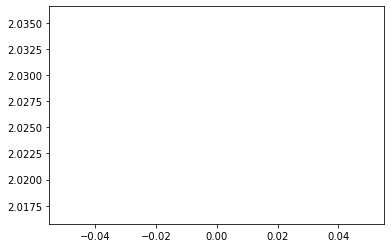

Epoch 1/1
----------
train Loss: 1.9400 Acc: 0.5583 Correct: 67.0
val Loss: 1.8577 Acc: 0.6937 Correct: 222.0


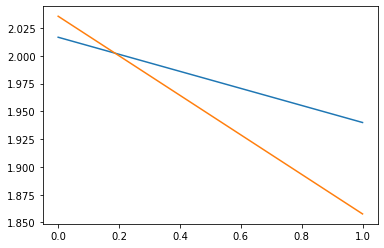

Training complete in 1m 31s
Best val Acc: 0.693750


XCM(
  (cnn_layers1_b1): Sequential(
    (conv_11): Conv2d(1, 16, kernel_size=(63, 63), stride=(1, 1), padding=(31, 31))
    (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_11): ReLU(inplace=True)
    (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_12): ReLU(inplace=True)
    (squeeze_12): Squeeze()
    (swap_12): SwapLastDim()
  )
  (cnn_layers2_b1): Sequential(
    (view_21): View(3, 315)
    (conv_21): Conv1d(3, 16, kernel_size=(63,), stride=(1,), padding=(31,))
    (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_21): ReLU(inplace=True)
    (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
    (relu_22): ReLU(inplace=True)
  )
  (cnn_layers3): Sequential(
    (swap_31): SwapLastDim()
    (conv_31): Conv1d(315, 32, kernel_size=(63,), stride=(1,), padding=(31,))
    (batchnorm_31): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [11]:
# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
model = net1
criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=4.5e-4)
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 2)

## Feature Extraction

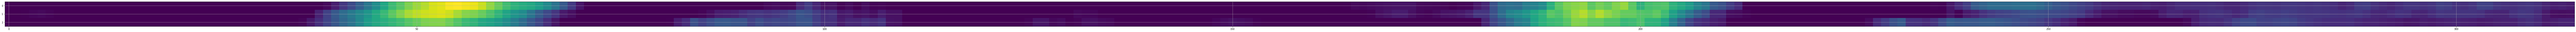

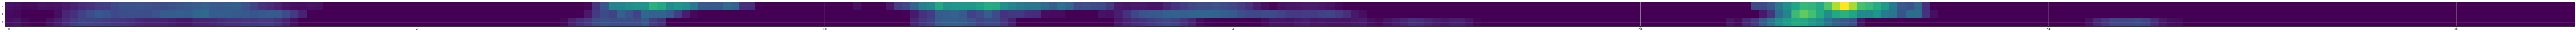

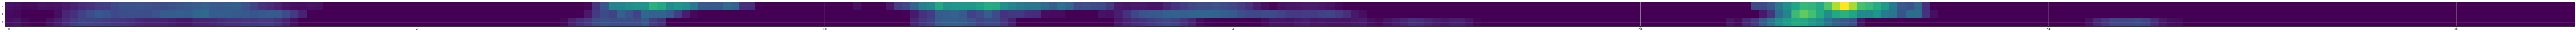

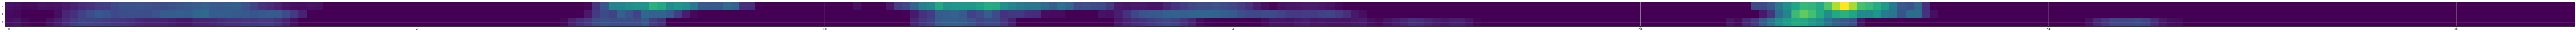

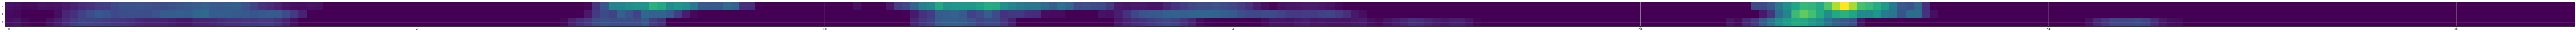

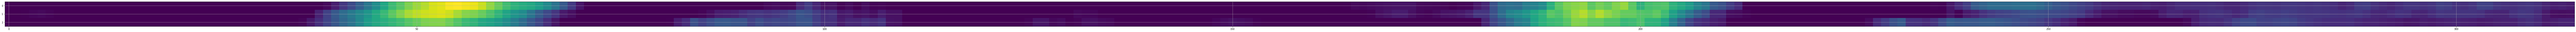

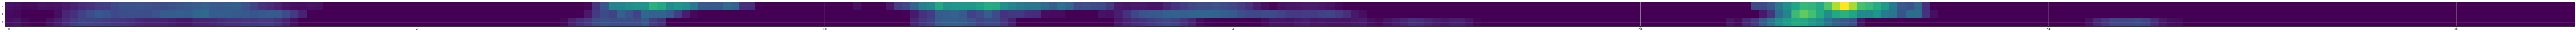

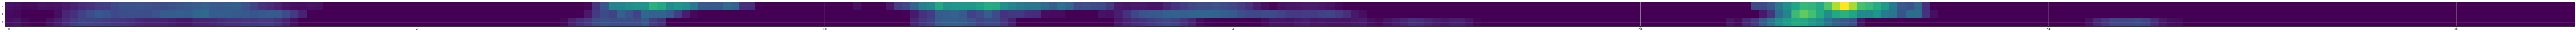

In [12]:
feature_maps = CAMFeatureMaps(GradCAM)
feature_maps.load(model,model.cnn_layers1_b1,'relu_11')
mask = {}
for i in range(len(np.unique(y_test))):
    mask[i] = feature_maps.show(X_test[0], i)

In [13]:
net1.cnn_layers2_b1

Sequential(
  (view_21): View(3, 315)
  (conv_21): Conv1d(3, 16, kernel_size=(63,), stride=(1,), padding=(31,))
  (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_21): ReLU(inplace=True)
  (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (relu_22): ReLU(inplace=True)
)

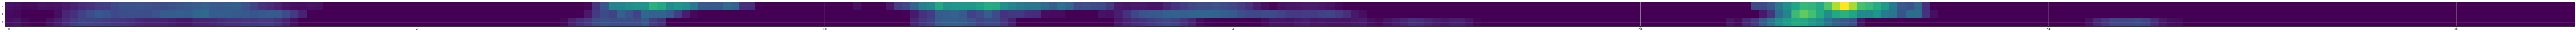

In [14]:
mask = feature_maps.show(X_test[0], 1)

In [32]:
X_test[0].shape[-1]

315

In [36]:
np.arange(0, X_test[0].shape[-1], 1)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

/Users/duypham/anaconda3/envs/XAI/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/Users/duypham/anaconda3/envs/XAI/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/Users/duypham/anaconda3/envs/XAI/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or 

ValueError: setting an array element with a sequence.

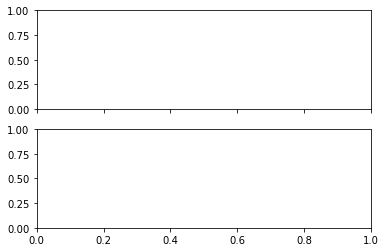

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.arange(0, X_test[0].shape[-1], 1)
# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points1 = np.array([x, X_test[0,0]]).T.reshape(-1, 1, 2)
points2 = np.array([x, X_test[0,1]]).T.reshape(-1, 1, 2)
points3 = np.array([x, X_test[0,2]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points1, points2, points3], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(mask.min(), mask.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(mask)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(X_test[0].T, ax=axs[0])

plt.show()

AttributeError: 'Line2D' object has no property 'norm'

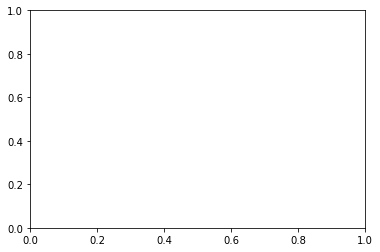

In [16]:
map_activation_to_input(X_test[0], mask)

In [ ]:
feature_maps = CAMFeatureMaps(GradCAMPlusPlus)
feature_maps.load(model,model.cnn_layers1_b1, 'relu_12')
mask1 = {}
for i in range(len(np.unique(y_test))):
    mask1[i] = feature_maps.show(X_test[0], i)

In [ ]:
mask1 = feature_maps.show(X_test[0], None)

In [ ]:
map_activation_to_input(X_test[0], mask1, 1)